## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

In [40]:
flights_6 = pd.read_csv('flights_data.csv', low_memory=False)

In [41]:
#pulling out states names 
flights_6[['origin_city_name','state']] = flights_6["origin_city_name"].str.split(',',expand=True)

In [42]:
#creating df with 2 columns
flights_data_2 = flights_data[['origin_city_name','state']]
flights_data_2 = flights_data_2[['state']].groupby('state').agg(state_count = ('state', 'size')).reset_index()

In [43]:
#new column for percent
summ = flights_data_2['state_count'].sum()
flights_data_2['percent'] = (flights_data_2['state_count']/summ*100)
flights_data_2 = flights_data_2.sort_values('percent', ascending=False)

In [44]:
flights_data_2['percent_cumulative'] = flights_data_2['percent'].copy()
flights_data_2['percent_cumulative'] = flights_data_2['percent_cumulative'].cumsum()
flights_data_2 = flights_data_2[flights_data_2['percent_cumulative'] <= 50.9]

In [45]:
print(flights_data_2 )

   state  state_count    percent  percent_cumulative
4     CA        37009  11.525765           11.525765
44    TX        32802  10.215573           21.741338
8     FL        26069   8.118705           29.860043
13    IL        20286   6.317697           36.177740
9     GA        16184   5.040206           41.217946
26    NC        14636   4.558110           45.776056
33    NY        14631   4.556553           50.332609


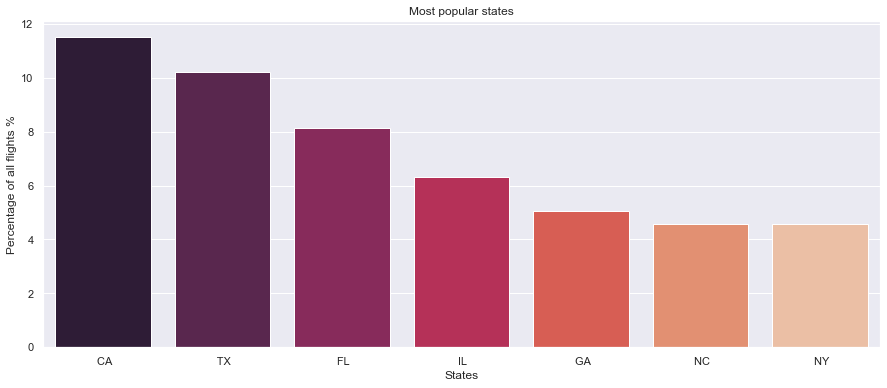

In [57]:
x = flights_data_2['state']
y = flights_data_2['percent']

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Most popular states")
plt.ylabel("Percentage of all flights %")
plt.xlabel("States")
plt.show()

In [46]:
print(len(flights_data_2))

7


7 states cover 50% of most popular US air traffic. These states are California, Texas, Florida, Illinois
Georgia, North Carolina and New York.

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

If null hypothesis that planes fly faster when there is the departure delay is true, then departure delay > arrival delay

In [47]:
flights_7 = pd.read_csv('flights_data.csv', low_memory=False)
#excluding diverted and canceled planes
flights_7 = flights_7[flights_7['diverted'] != 1]
flights_7 = flights_7[flights_7['cancelled'] != 1]

In [48]:
#dropping early departures
flights_7.drop(flights_7[flights_7.dep_delay < 0].index, inplace=True)

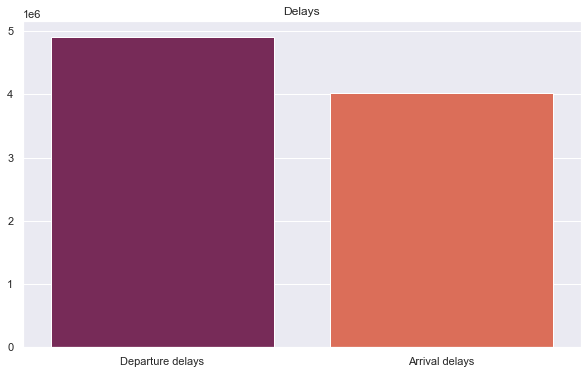

In [53]:
x = ["Departure delays", "Arrival delays"]
y = [flights_7['dep_delay'].sum(),flights_7['arr_delay'].sum()]

plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Delays")
plt.show()

In [49]:
x = flights_7['dep_delay'].sum()/flights_7['arr_delay'].sum()
print(x)

1.2201523473806415


Planes fly faster when there is the departure delay

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [2]:
flights_data = pd.read_csv('flights_data.csv', low_memory=False)

In [3]:
# adding new column 'hour'

flights_data.dropna(subset=['dep_time', 'air_time'], inplace=True)
flights_data['hour'] = flights_data['dep_time'].floordiv(100).astype(int)

In [4]:
# adding new column 'flight_length'
# 1 for Short-Haul from 30 minutes to 3 hours
# 2 for Medium-Haul 3-6 hours
# 3 for Long-Haul over 6 hours
flights_data['flight_length'] = flights_data['air_time'].copy()
flights_data['flight_length'].mask(flights_data['flight_length'] < 180, 1, inplace=True)
flights_data['flight_length'].mask((flights_data['flight_length'] >= 180) & (flights_data['flight_length'] < 360), 2, inplace=True)
flights_data['flight_length'].mask(flights_data['flight_length'] >= 360, 3, inplace=True)

In [6]:
df_8 = flights_data[['flight_length', 'hour']].copy()

print(df_8[df_8['flight_length'] == 1.].mode())
print(df_8[df_8['flight_length'] == 2.].mode())
print(df_8[df_8['flight_length'] == 3.].mode())

   flight_length  hour
0            1.0    17
   flight_length  hour
0            2.0     8
   flight_length  hour
0            3.0    11


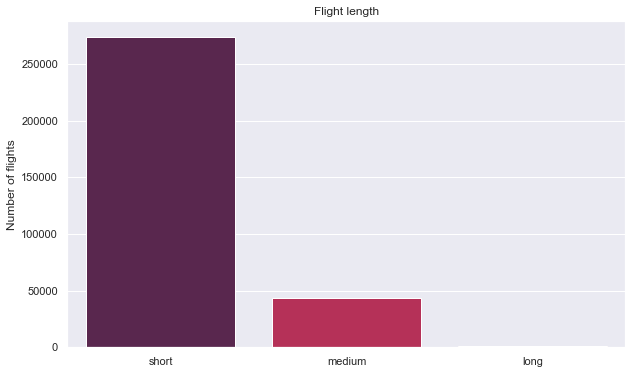

In [18]:
x = ["short","medium","long"]
y = [len(df_8[df_8['flight_length'] == 1.]),len(df_8[df_8['flight_length'] == 2.]), len(df_8[df_8['flight_length'] == 3.])]

plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Flight length")
plt.ylabel("Number of flights")
plt.show()

Most short-haul flights take off at 5 pm, medium-haul flights at 8 am, long-haul flights at 11 am. Most of the flights are short-haul flights.

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?